In [13]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

# test pytorch device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [14]:
df = pd.read_csv("../data/camelyon17_v1.0/metadata.csv")

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 455954 entries, 0 to 455953
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   Unnamed: 0  455954 non-null  int64
 1   patient     455954 non-null  int64
 2   node        455954 non-null  int64
 3   x_coord     455954 non-null  int64
 4   y_coord     455954 non-null  int64
 5   tumor       455954 non-null  int64
 6   slide       455954 non-null  int64
 7   center      455954 non-null  int64
 8   split       455954 non-null  int64
dtypes: int64(9)
memory usage: 31.3 MB


In [16]:
def make_path(row):
    p = f"{row.patient:03d}"
    return (
        f"../data/camelyon17_v1.0/patches/"
        f"patient_{p}_node_{row.node}/"
        f"patch_patient_{p}_node_{row.node}_x_{row.x_coord}_y_{row.y_coord}.png"
    )

df["img_path"] = df.apply(make_path, axis=1)
df.head()

,Unnamed: 0,patient,node,x_coord,y_coord,tumor,slide,center,split,img_path
0,0,4,4,3328,21792,1,0,0,0,../data/camelyon17_v1.0/patches/patient_004_no...
1,1,4,4,3200,22272,1,0,0,0,../data/camelyon17_v1.0/patches/patient_004_no...
2,2,4,4,3168,22272,1,0,0,0,../data/camelyon17_v1.0/patches/patient_004_no...
3,3,4,4,3328,21760,1,0,0,0,../data/camelyon17_v1.0/patches/patient_004_no...
4,4,4,4,3232,22240,1,0,0,0,../data/camelyon17_v1.0/patches/patient_004_no...


In [17]:
cat_cols = ["patient", "node", "slide", "center"]
cont_cols = ["x_coord", "y_coord"]

# Create label encoders for categorical columns to map to 0-indexed consecutive integers
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df[f"{col}_encoded"] = le.fit_transform(df[col])
    label_encoders[col] = le
    print(f"{col}: {df[col].nunique()} unique values -> encoded to 0-{len(le.classes_)-1}")

# Update to use encoded columns
cat_cols_encoded = [f"{col}_encoded" for col in cat_cols]

# IMPORTANT: Recreate train/val splits AFTER encoding
train_df = df[df["split"] == 0].copy()
val_df = df[df["split"] == 1].copy()

print("\nTrain set size:", len(train_df))
print("Validation set size:", len(val_df))

scaler = StandardScaler()
train_cont = scaler.fit_transform(train_df[cont_cols])
val_cont = scaler.transform(val_df[cont_cols])

patient: 43 unique values -> encoded to 0-42
node: 5 unique values -> encoded to 0-4
slide: 50 unique values -> encoded to 0-49
center: 5 unique values -> encoded to 0-4

Train set size: 410359
Validation set size: 45595


In [18]:
class CamelyonDataset(Dataset):
    def __init__(self, df, cont_array, transform=None):
        self.df = df.reset_index(drop=True)
        self.cont = cont_array.astype(np.float32)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row.img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)

        # Use encoded categorical columns
        cat = torch.tensor([int(row[col]) for col in cat_cols_encoded], dtype=torch.long)
        cont = torch.tensor(self.cont[idx], dtype=torch.float32)
        y = torch.tensor(row.tumor, dtype=torch.float32)
        return img, cat, cont, y

In [19]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_ds = CamelyonDataset(train_df, train_cont, transform=transform)
val_ds = CamelyonDataset(val_df, val_cont, transform=transform)

# On Windows, num_workers must be 0 to avoid multiprocessing issues in notebooks
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=0)

In [20]:
class MultiModalModel(nn.Module):
    def __init__(self, cat_sizes, cont_dim, emb_dim=8, hidden=128):
        super().__init__()
        # CNN
        self.cnn = models.resnet18(weights=None)
        self.cnn.fc = nn.Identity()
        cnn_out = 512

        # Embeddings categoriels
        self.embeddings = nn.ModuleList([
            nn.Embedding(size, emb_dim) for size in cat_sizes
        ])
        emb_out = emb_dim * len(cat_sizes)

        # MLP meta
        self.meta_mlp = nn.Sequential(
            nn.Linear(emb_out + cont_dim, hidden),
            nn.ReLU(),
            nn.Dropout(0.2),
        )

        # Tete finale
        self.classifier = nn.Sequential(
            nn.Linear(cnn_out + hidden, 1)
        )

    def forward(self, img, cat, cont):
        img_feat = self.cnn(img)
        emb_list = [emb(cat[:, i]) for i, emb in enumerate(self.embeddings)]
        meta = torch.cat(emb_list + [cont], dim=1)
        meta_feat = self.meta_mlp(meta)
        fused = torch.cat([img_feat, meta_feat], dim=1)
        logits = self.classifier(fused).squeeze(1)
        return logits


In [21]:
cat_sizes = [df[c].nunique() for c in cat_cols_encoded]
print("Embedding sizes:", cat_sizes)

model = MultiModalModel(cat_sizes, cont_dim=len(cont_cols)).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

Embedding sizes: [43, 5, 50, 5]


In [22]:
def run_epoch(loader, train=True):
    model.train() if train else model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    mode = "Train" if train else "Val"
    pbar = tqdm(loader, desc=f"{mode}", leave=True)

    for imgs, cats, conts, y in pbar:
        imgs, cats, conts, y = imgs.to(device), cats.to(device), conts.to(device), y.to(device)
        logits = model(imgs, cats, conts)
        loss = criterion(logits, y)

        if train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * y.size(0)
        preds = (torch.sigmoid(logits) > 0.5).float()
        correct += (preds == y).sum().item()
        total += y.size(0)

        # Update progress bar with current metrics
        pbar.set_postfix({
            'loss': f'{total_loss/total:.4f}',
            'acc': f'{correct/total:.4f}'
        })

    return total_loss / total, correct / total

In [23]:
# LOAD THE MODEL
model = MultiModalModel(cat_sizes, cont_dim=len(cont_cols)).to(device)
model.load_state_dict(torch.load("multimodal_camelyon_model.pth"))
model.eval()

MultiModalModel(
  (cnn): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [24]:
# Test et analyse du modèle afin de déterminer les taux de faux négatifs et faux positifs
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, cats, conts, y in tqdm(val_loader, desc="Testing", leave=True):
        imgs, cats, conts = imgs.to(device), cats.to(device), conts.to(device)
        logits = model(imgs, cats, conts)
        preds = (torch.sigmoid(logits) > 0.5).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(y.numpy())
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)


Testing: 100%|██████████| 713/713 [05:19<00:00,  2.23it/s]


In [25]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(all_labels, all_preds)
tn, fp, fn, tp = cm.ravel()
print("Confusion Matrix:")
print(cm)
print(f"False Positives: {fp}, False Negatives: {fn}")

# tests complémentaires: Recall, Précision, F-Beta score
from sklearn.metrics import precision_score, recall_score, fbeta_score
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f2 = fbeta_score(all_labels, all_preds, beta=2)
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F2 Score: {f2:.4f}")

# Coefficient de corrélation de Matthews MCC
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(all_labels, all_preds)
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")

# score kappa de Cohen
from sklearn.metrics import cohen_kappa_score
kappa = cohen_kappa_score(all_labels, all_preds)
print(f"Cohen's Kappa Score: {kappa:.4f}")

# AUC-PR and AUC-ROC
from sklearn.metrics import roc_auc_score, average_precision_score
roc_auc = roc_auc_score(all_labels, all_preds)
pr_auc = average_precision_score(all_labels, all_preds)
print(f"AUC-ROC: {roc_auc:.4f}, AUC-PR: {pr_auc:.4f}")

Confusion Matrix:
[[22731   215]
 [  322 22327]]
False Positives: 215, False Negatives: 322
Precision: 0.9905, Recall: 0.9858, F2 Score: 0.9867
Matthews Correlation Coefficient (MCC): 0.9765
Cohen's Kappa Score: 0.9764
AUC-ROC: 0.9882, AUC-PR: 0.9834


Calibration: 100%|██████████| 713/713 [01:10<00:00, 10.13it/s]


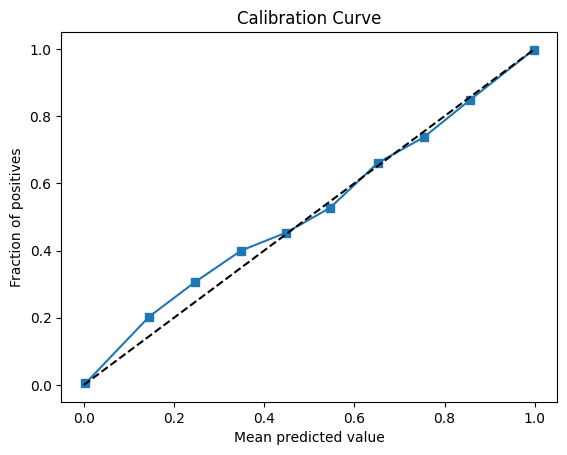

In [26]:
# Erreur de Calibration (Expected Calibration Error - ECE)
from sklearn.calibration import calibration_curve
prob_preds = []
with torch.no_grad():
    for imgs, cats, conts, y in tqdm(val_loader, desc="Calibration", leave=True):
        imgs, cats, conts = imgs.to(device), cats.to(device), conts.to(device)
        logits = model(imgs, cats, conts)
        probs = torch.sigmoid(logits).cpu().numpy()
        prob_preds.extend(probs)
prob_preds = np.array(prob_preds)
fraction_of_positives, mean_predicted_value = calibration_curve(all_labels, prob_preds, n_bins=10)
import matplotlib.pyplot as plt
plt.plot(mean_predicted_value, fraction_of_positives, "s-")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of positives")
plt.title("Calibration Curve")
plt.show()